In [5]:
import pandas as pd
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()
entity = "magalhaes"
project = "Audio"

runs = api.runs(f"{entity}/{project}")

In [6]:
summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

summary_df = pd.DataFrame.from_records(summary_list)

summary_df['name'] = name_list

# FIlter summary_df to only include rows with "name" containing "MData" and NOT containing "split"
summary_df = summary_df[summary_df['name'].str.contains("MData") & ~summary_df['name'].str.contains("split")]

# Remove "Precomputed_Spec_MData_" from "name" column
summary_df['name'] = summary_df['name'].str.replace("Precomputed_Spec_MData_", "")

# Separate the "name" into "Augmentation" and "RunID" where the "name" is NameOfAugmentationRunID, but RunID is a number. Eg AddGaussianNoise0
summary_df[['Augmentation', 'RunID']] = summary_df['name'].str.split('(?<=\D)(?=\d)', expand=True)

# Remove the "name" column
summary_df = summary_df.drop(columns=['name'])

# Reduce columns to "Name", "Recall", "F1 score", "Precision", "Accuracy"
summary_df = summary_df[["Augmentation", "RunID", "F1 score", "Recall", "Precision", "Accuracy"]]

# Sort by augmentation
summary_df = summary_df.sort_values(by=['Augmentation'], ascending=False)

# Sort by augmentation, then by f1-score
# summary_df = summary_df.sort_values(by=['Augmentation', 'F1 score'], ascending=False)

# Rename f1 score to F1Score
summary_df = summary_df.rename(columns={"F1 score": "F1-Score"})

# Remove the ids
summary_df = summary_df.reset_index(drop=True)

summary_df

,Augmentation,RunID,F1-Score,Recall,Precision,Accuracy
0,TimeStretch,1,0.520698,0.779298,0.447048,0.807370
1,TimeStretch,2,0.533716,0.782784,0.455627,0.812435
2,TimeStretch,3,0.537989,0.788765,0.460770,0.803353
3,TimeStretch,0,0.534976,0.785290,0.454625,0.808767
4,TimeMasking_Gain,None,0.555015,0.736154,0.490977,0.799773
...,...,...,...,...,...,...
85,AddGaussianNoise,3,0.519765,0.777948,0.439936,0.808576
86,AddGaussianNoise,5,0.530943,0.774684,0.452716,0.807598
87,AddGaussianNoise,None,0.535538,0.812904,0.454328,0.817499
88,AddGaussianNoise,4,0.527611,0.772055,0.453513,0.810870


In [7]:
df = summary_df

# Calculate the difference in F1-Score compared to Base 0
base_f1_score = df[df["Augmentation"] == "Base"]["F1-Score"].values[0]
df["Difference"] = (df["F1-Score"] - base_f1_score) * 100

# Filter out rows with NaN values in the F1-Score
df = df[(df["Augmentation"] != "Base") & ~df["F1-Score"].isna()]

/tmp/ipykernel_24075/2948887680.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap


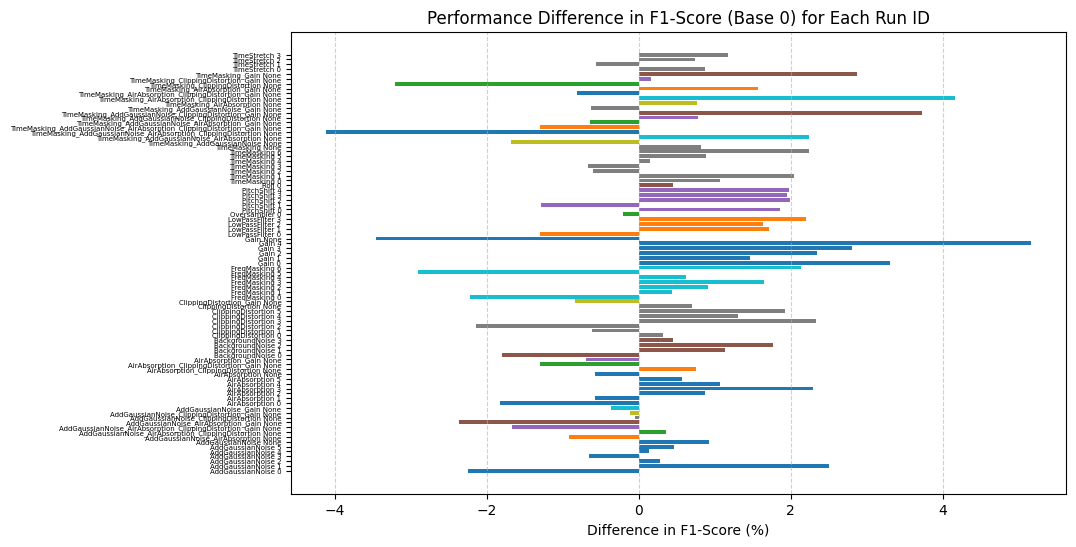

In [8]:
# Create a horizontal bar chart for each augmentation type
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap

# Sort them alphabetically, then by runid
df = df.sort_values(by=["Augmentation", "RunID"])

for i, (augmentation, group) in enumerate(df.groupby("Augmentation")):
    color = colors(i % len(df["RunID"].unique()))  # Cycle through colors
    plt.barh([augmentation + f" {run_id}" for run_id in group["RunID"]], group["Difference"], color=color, label=augmentation)

# Lower the y-axis label font size
plt.yticks(fontsize=5)

plt.xlabel('Difference in F1-Score (%)')
plt.title('Performance Difference in F1-Score (Base 0) for Each Run ID')
plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.legend()

plt.show()

In [14]:
# Separate the augmentations by wether they are a combination of other augmentations or not
df["IsCombined"] = df["Augmentation"].str.split("_").apply(lambda x: len(x) > 1)

# Create a horizontal bar chart for each augmentation type
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap

# Sort them by f1-score
df = df.sort_values(by=["F1-Score"], ascending=False)

# Display the results in a table
df

/tmp/ipykernel_24075/3037970653.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(df["RunID"].unique()))  # Use a different colormap


,Augmentation,RunID,F1-Score,Recall,Precision,Accuracy,Difference,IsCombined
43,Gain,4,0.577895,0.766797,0.499796,0.812726,5.160844,False
9,TimeMasking_AirAbsorption_ClippingDistortion,None,0.567871,0.735473,0.493565,0.797241,4.158367,True
12,TimeMasking_AddGaussianNoise_ClippingDistortio...,None,0.563624,0.756355,0.490752,0.810339,3.733664,True
39,Gain,0,0.559394,0.783629,0.475826,0.810496,3.310668,False
4,TimeMasking_Gain,None,0.555015,0.736154,0.490977,0.799773,2.872759,True
...,...,...,...,...,...,...,...,...
79,AddGaussianNoise_AirAbsorption_Gain,None,0.502599,0.796956,0.430336,0.803353,-2.368831,True
51,FreqMasking,5,0.497218,0.770438,0.423466,0.807546,-2.906914,False
6,TimeMasking_ClippingDistortion,None,0.494174,0.746624,0.423197,0.809291,-3.211339,True
44,Gain,None,0.491647,0.796907,0.420270,0.809466,-3.463964,False


<Figure size 1000x600 with 0 Axes>

In [9]:
#Get the 5 best performing augmentations, one per type
best_augmentations = []
for augmentation, group in df.groupby("Augmentation"):
    best_augmentations.append(group.sort_values(by="Difference", ascending=False).iloc[0])

# SOrt by difference
best_augmentations = sorted(best_augmentations, key=lambda x: x["Difference"], reverse=True)

# Print the best augmentations
print("Best augmentations:")
for augmentation in best_augmentations:
    print(f"{augmentation['Augmentation']} {augmentation['RunID']} with a difference of {augmentation['Difference']}%")

Best augmentations:
Gain 4 with a difference of 5.160843699756801%
TimeMasking_AirAbsorption_ClippingDistortion None with a difference of 4.158366564476534%
TimeMasking_AddGaussianNoise_ClippingDistortion_Gain None with a difference of 3.733663925783659%
TimeMasking_Gain None with a difference of 2.8727594075917184%
AddGaussianNoise 1 with a difference of 2.506085194687846%
ClippingDistortion 3 with a difference of 2.3334264321642317%
AirAbsorption 3 with a difference of 2.2873365978253846%
TimeMasking 6 with a difference of 2.2424850913214778%
TimeMasking_AddGaussianNoise_AirAbsorption None with a difference of 2.2403483074232677%
LowPassFilter 3 with a difference of 2.1993426401693106%
FreqMasking 6 with a difference of 2.1305738229694615%
PitchShift 2 with a difference of 1.985855575238371%
BackgroundNoise 2 with a difference of 1.772278454480114%
TimeMasking_AirAbsorption_Gain None with a difference of 1.56352275991396%
TimeStretch 3 with a difference of 1.1701462529476236%
TimeMas